In [1]:
import numpy as np
import pandas as pd

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

from glob import glob
import os

In [100]:
df_exp_100 = pd.read_csv('../../results/experiments/sim_costs_load=3482_pv=7989 6423_numsteps=100.csv', index_col=0)
df_exp_40 = pd.read_csv('../../results/experiments/sim_costs_load=3482_pv=7989 6423_numsteps=40.csv', index_col=0)
df_exp_6423_40 = pd.read_csv('../../results/experiments/sim_costs_load=6423_pv=7989 6423_numsteps=40.csv', index_col=0)
df_exp_cmp = pd.read_csv('../../results/experiments/sim_costs_load=3482_pv=7989 6423_cmp.csv', index_col=0)
df_exp_20 = pd.read_csv('../../results/experiments/sim_costs_load=3482_pv=7989 6423_numsteps=20.csv', index_col=0)
df_exp_6423_20 = pd.read_csv('../../results/experiments/sim_costs_load=6423_pv=7989 6423_numsteps=20.csv', index_col=0)

In [101]:
df_exp_100_cheby = pd.read_csv('../../results/full_search/load=3482_pv=7989 6423/cheby/summary.csv')
df_exp_40_cheby = pd.read_csv('../../results/full_search/load=3482_pv=7989 6423_numsteps=40/cheby/summary.csv')
df_exp_6423_40_cheby = pd.read_csv('../../results/full_search/load=6423_pv=7989 6423_numsteps=40/cheby/summary.csv')

In [65]:
def fix_rows(orig_df, new_df):
    for i, row in new_df.iterrows():
        cond = (orig_df['sim_type'] == 'chebyshev') & \
               (orig_df['confidence'] == row['confidence']) & \
               (orig_df['days_in_chunk'] == row['days_in_chunk']) & \
               (orig_df['effective_epsilon'] == row['epsilon'])

        assert len(orig_df[cond]) == 1, row

        orig_df.loc[cond, 'pv1'] = row['pv1']
        orig_df.loc[cond, 'pv2'] = row['pv2']
        orig_df.loc[cond, 'battery'] = row['battery']
        orig_df.loc[cond, 'cost'] = row['cost']

In [66]:
fix_rows(df_exp_100, df_exp_100_cheby)
fix_rows(df_exp_40, df_exp_40_cheby)
fix_rows(df_exp_6423_40, df_exp_6423_40_cheby)

AssertionError: days_in_chunk      365.000000
confidence           0.850000
epsilon              0.550000
battery             10.181747
pv1                  0.000000
pv2                  9.752360
cost             11967.100000
Name: 12, dtype: float64

In [102]:
df_exp_100.to_csv('../../results/experiments/sim_costs_load=3482_pv=7989 6423_numsteps=100.csv')
df_exp_40.to_csv('../../results/experiments/sim_costs_load=3482_pv=7989 6423_numsteps=40.csv')
df_exp_6423_40.to_csv('../../results/experiments/sim_costs_load=6423_pv=7989 6423_numsteps=40.csv')

In [103]:
df_exp = df_exp_100[df_exp_100['sim_type'] == 'chebyshev'] \
        .append(df_exp_40[df_exp_40['sim_type'] == 'chernoff']) \
        .reset_index(drop=True)

In [104]:
df_exp

,sim_type,days_in_chunk,confidence,epsilon,p,effective_epsilon,battery,pv1,pv2,cost,duration,total_sim_called
0,chebyshev,100,0.85,0.1,0.9,0.19,38.725497,25.091280,0.000000,33908.4,1699,3483438
1,chebyshev,200,0.85,0.1,0.9,0.19,39.648580,0.000000,22.293151,32970.9,3666,3439338
2,chebyshev,365,0.85,0.1,0.9,0.19,38.434453,0.000000,18.251959,30343.2,7892,3275818
3,chebyshev,100,0.95,0.1,0.9,0.19,32.797183,27.920943,8.614361,38666.2,5091,10411366
4,chebyshev,200,0.95,0.1,0.9,0.19,42.209233,0.000000,27.647613,36928.4,11768,10340505
...,...,...,...,...,...,...,...,...,...,...,...,...
79,chernoff,365,0.85,0.5,0.8,0.60,12.500000,0.000000,10.000000,13250.0,5072,3574000
80,chernoff,365,0.85,0.5,0.5,0.75,11.250000,0.000000,10.000000,12625.0,5374,3574000
81,chernoff,365,0.95,0.5,0.9,0.55,13.750000,0.000000,10.000000,13875.0,5093,3566000
82,chernoff,365,0.95,0.5,0.8,0.60,12.500000,0.000000,10.000000,13250.0,5054,3571000


## Plots

In [105]:
def plot_by_daysinchunk(df):
    for (effective_epsilon, p), df_split in df.groupby(['effective_epsilon', 'p']):
        epsilon = df_split.iloc[-1]['epsilon']
        print(epsilon, p, effective_epsilon)

        fig, (ax_cost, ax_simcalled) = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle(f'load_id={3842}, epsilon={epsilon}, p={p}, effective={effective_epsilon}')

        ax_cost.set_title('sizing cost vs. days_in_chunk')
        ax_cost.set_ylabel('cost ($)')
        ax_cost.set_xlabel('days_in_chunk')

        ax_simcalled.set_title('duration (s) vs. days_in_chunk')
        ax_simcalled.set_ylabel('duration (s)')
        ax_simcalled.set_xlabel('days_in_chunk')

        lgds = []
        for idx, ((sim_type, conf), df_conf) in enumerate(df_split.groupby(['sim_type', 'confidence'])):
            print(sim_type, conf, len(df_conf))
            ax_cost.scatter(df_conf['days_in_chunk'], df_conf['cost'])
            ax_simcalled.scatter(df_conf['days_in_chunk'], df_conf['duration'])
            lgds.append(f'{sim_type}, conf={conf}')

        plt.legend(lgds)
        plt.show()

0.1 0.9 0.19
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


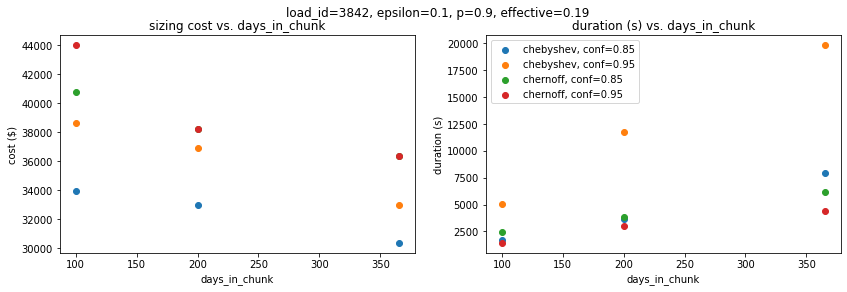

0.1 0.8 0.28
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


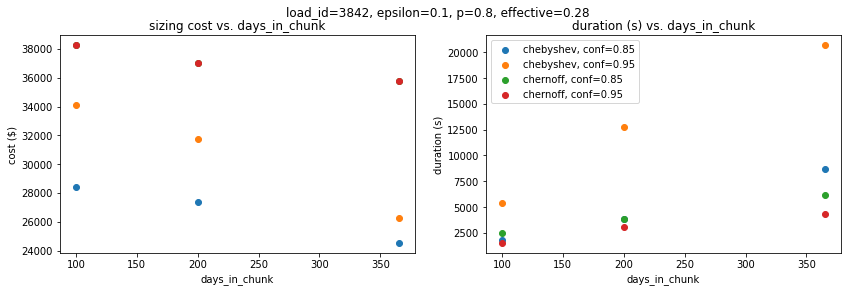

0.3 0.9 0.37
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


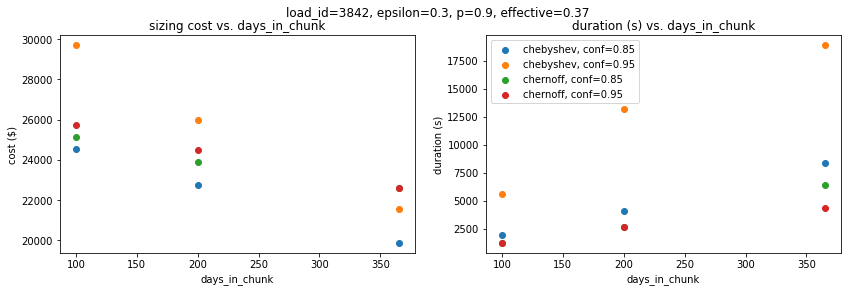

0.3 0.8 0.44
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


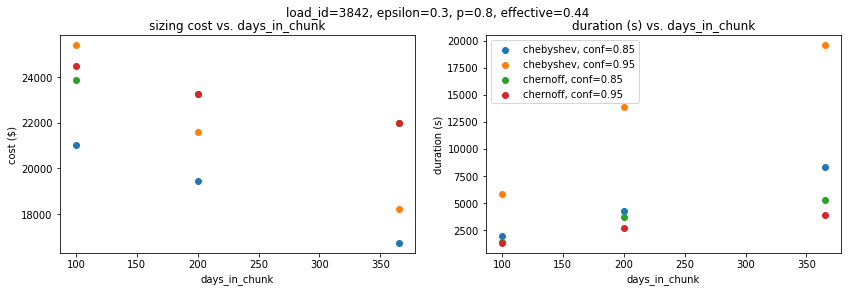

0.1 0.5 0.55
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


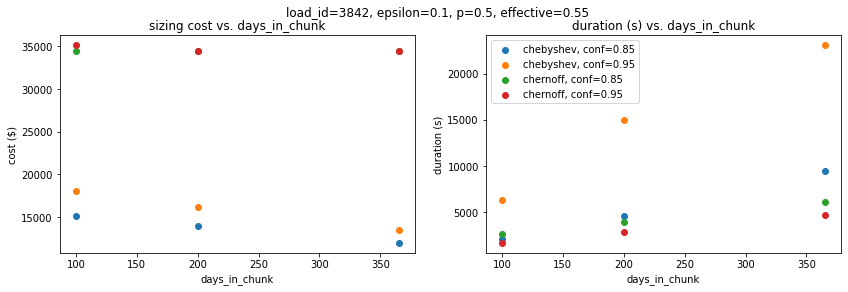

0.5 0.9 0.55
chebyshev 0.85 1
chebyshev 0.95 1
chernoff 0.85 1
chernoff 0.95 1


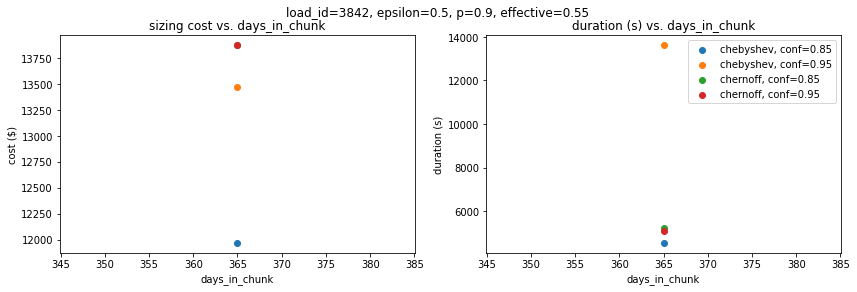

0.5 0.8 0.6
chebyshev 0.85 1
chebyshev 0.95 1
chernoff 0.85 1
chernoff 0.95 1


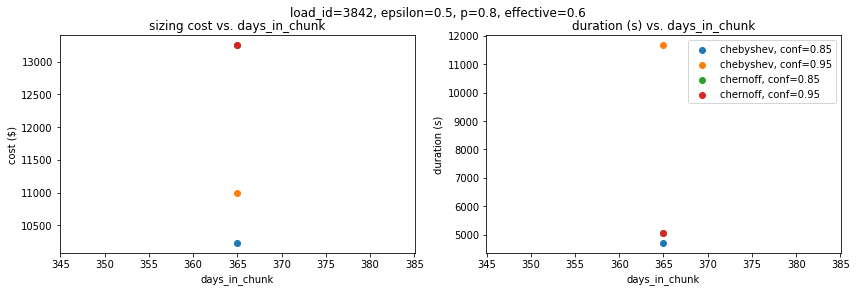

0.3 0.5 0.65
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


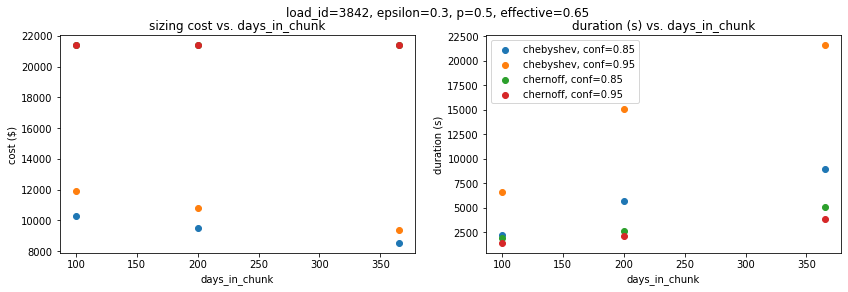

0.5 0.5 0.75
chebyshev 0.85 1
chebyshev 0.95 1
chernoff 0.85 1
chernoff 0.95 1


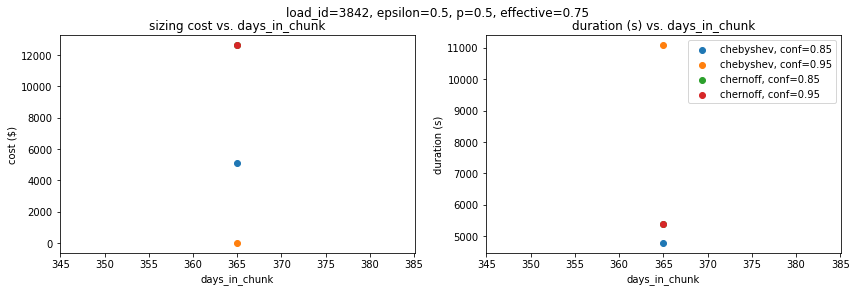

In [106]:
plot_by_daysinchunk(df_exp)

In [107]:
def plot_by_p(df):
    for (epsilon, days_in_chunk), df_split in df.groupby(['epsilon', 'days_in_chunk']):
        print(epsilon, days_in_chunk)

        fig, (ax_cost, ax_simcalled) = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle(f'load_id={3842}, epsilon={epsilon}, days_in_chunk={days_in_chunk}')

        ax_cost.set_title('sizing cost vs. p')
        ax_cost.set_ylabel('cost ($)')
        ax_cost.set_xlabel('p')

        ax_simcalled.set_title('duration (s) vs. p')
        ax_simcalled.set_ylabel('duration (s)')
        ax_simcalled.set_xlabel('p')

        lgds = []
        for idx, ((sim_type, conf), df_conf) in enumerate(df_split.groupby(['sim_type', 'confidence'])):
            print(sim_type, conf, len(df_conf))
            ax_cost.scatter(df_conf['p'], df_conf['cost'])
            ax_simcalled.scatter(df_conf['p'], df_conf['duration'])
            lgds.append(f'{sim_type}, conf={conf}')

        plt.legend(lgds)
        plt.show()

0.1 100
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


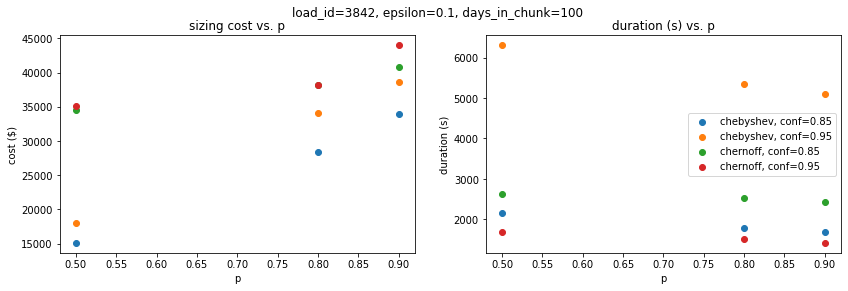

0.1 200
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


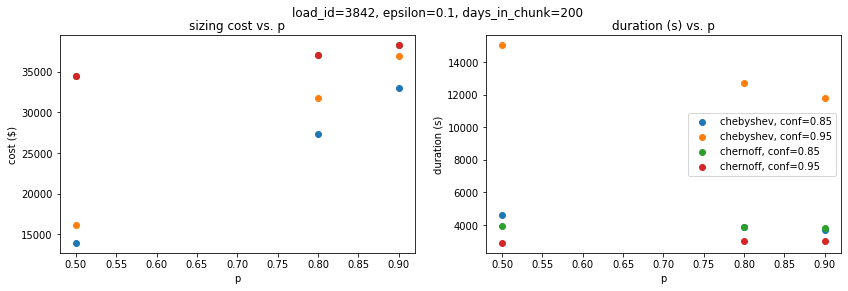

0.1 365
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


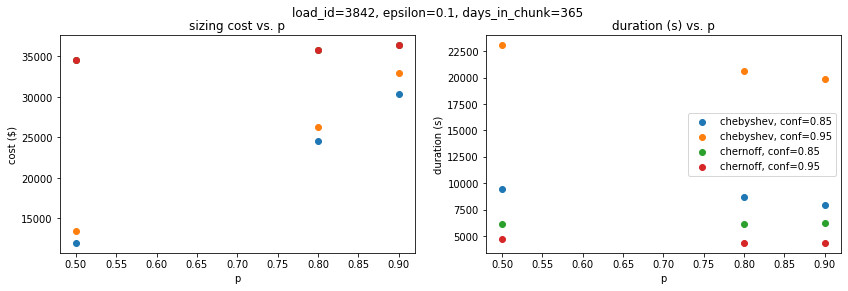

0.3 100
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


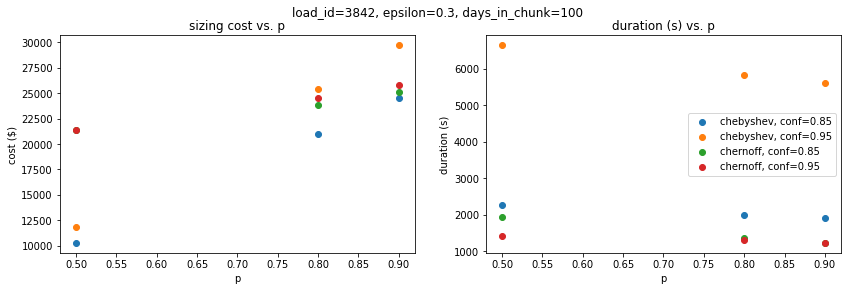

0.3 200
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


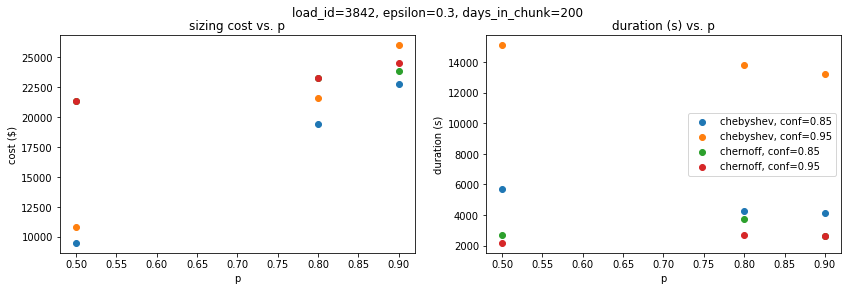

0.3 365
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


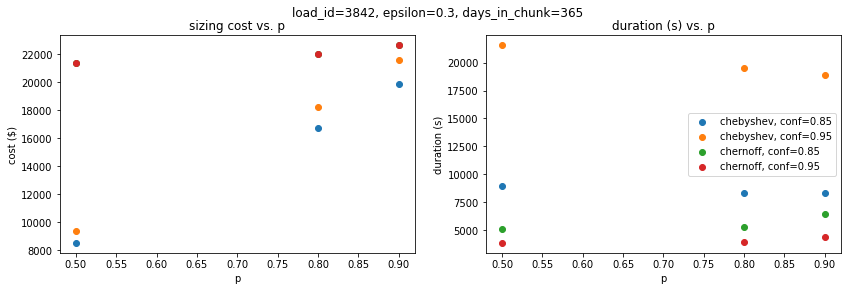

0.5 365
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


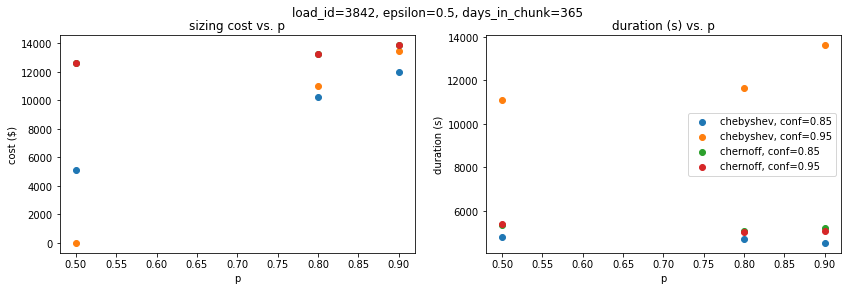

In [108]:
plot_by_p(df_exp)

In [109]:
def plot_by_epsilon(df):
    for (p, days_in_chunk), df_split in df.groupby(['p', 'days_in_chunk']):
        print(p, days_in_chunk)

        fig, (ax_cost, ax_simcalled) = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle(f'load_id={3842}, p={p}, days_in_chunk={days_in_chunk}')

        ax_cost.set_title('sizing cost vs. epsilon')
        ax_cost.set_ylabel('cost ($)')
        ax_cost.set_xlabel('epsilon')

        ax_simcalled.set_title('duration (s) vs. epsilon')
        ax_simcalled.set_ylabel('duration (s)')
        ax_simcalled.set_xlabel('epsilon')

        lgds = []
        for idx, ((sim_type, conf), df_conf) in enumerate(df_split.groupby(['sim_type', 'confidence'])):
            print(sim_type, conf, len(df_conf))
            ax_cost.scatter(df_conf['epsilon'], df_conf['cost'])
            ax_simcalled.scatter(df_conf['epsilon'], df_conf['duration'])
            lgds.append(f'{sim_type}, conf={conf}')

        plt.legend(lgds)
        plt.show()

0.5 100
chebyshev 0.85 2
chebyshev 0.95 2
chernoff 0.85 2
chernoff 0.95 2


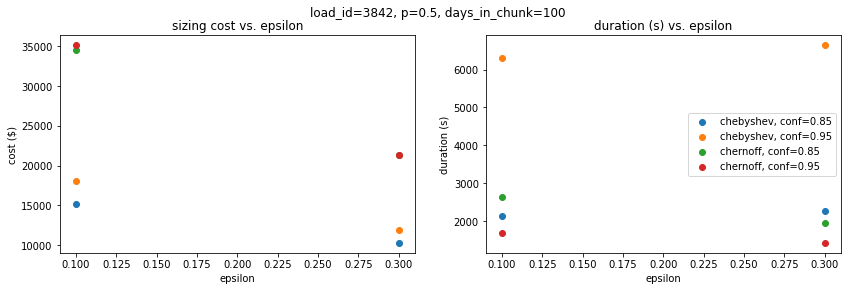

0.5 200
chebyshev 0.85 2
chebyshev 0.95 2
chernoff 0.85 2
chernoff 0.95 2


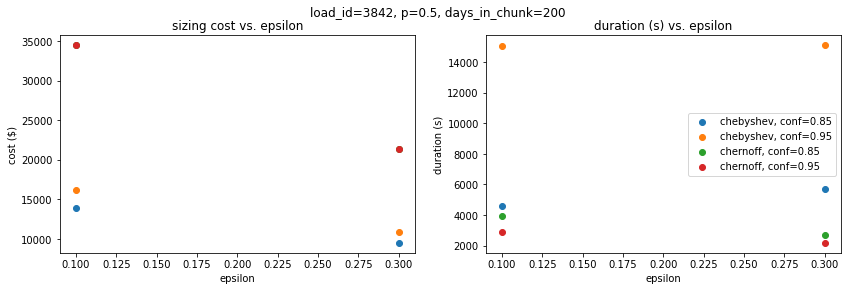

0.5 365
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


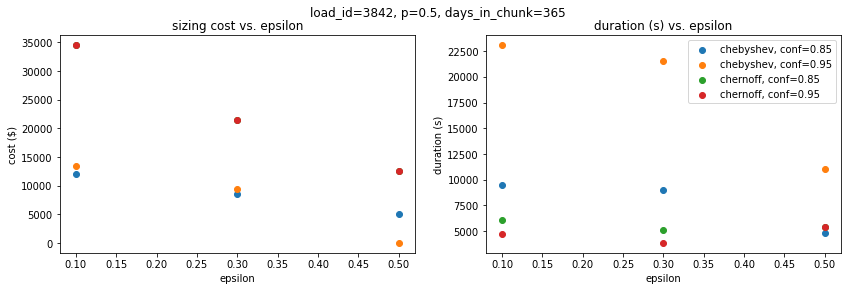

0.8 100
chebyshev 0.85 2
chebyshev 0.95 2
chernoff 0.85 2
chernoff 0.95 2


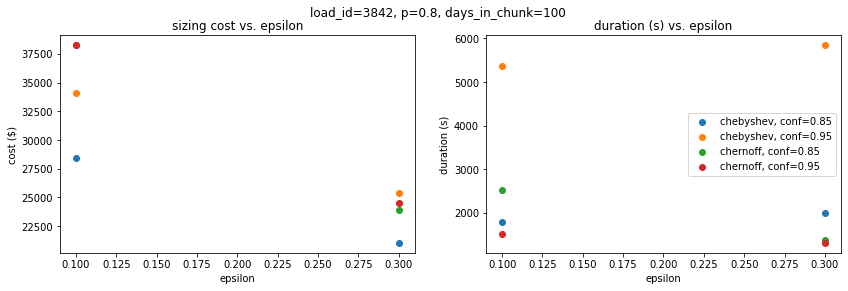

0.8 200
chebyshev 0.85 2
chebyshev 0.95 2
chernoff 0.85 2
chernoff 0.95 2


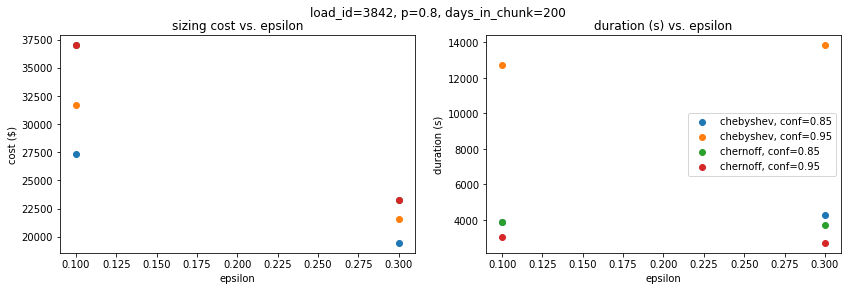

0.8 365
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


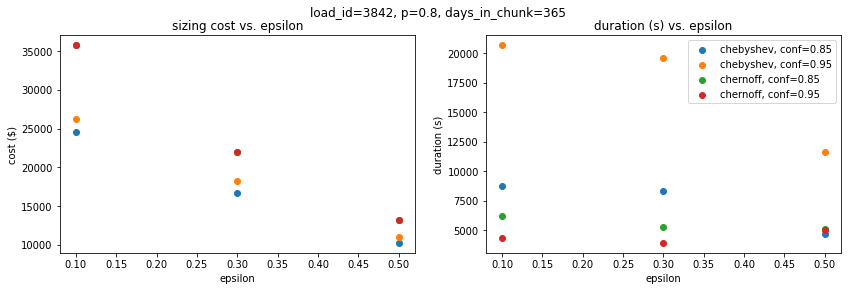

0.9 100
chebyshev 0.85 2
chebyshev 0.95 2
chernoff 0.85 2
chernoff 0.95 2


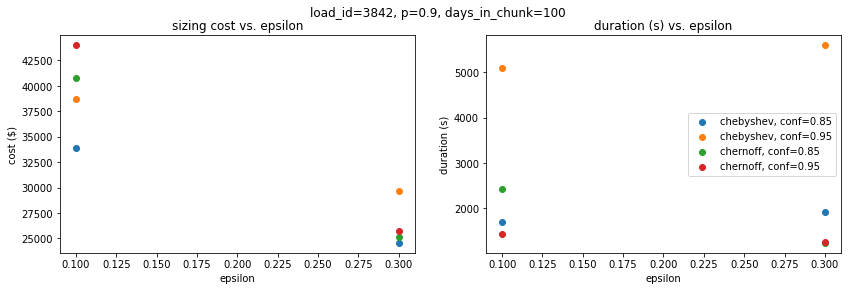

0.9 200
chebyshev 0.85 2
chebyshev 0.95 2
chernoff 0.85 2
chernoff 0.95 2


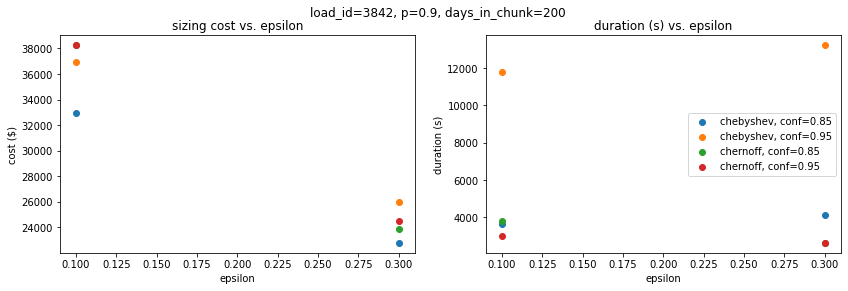

0.9 365
chebyshev 0.85 3
chebyshev 0.95 3
chernoff 0.85 3
chernoff 0.95 3


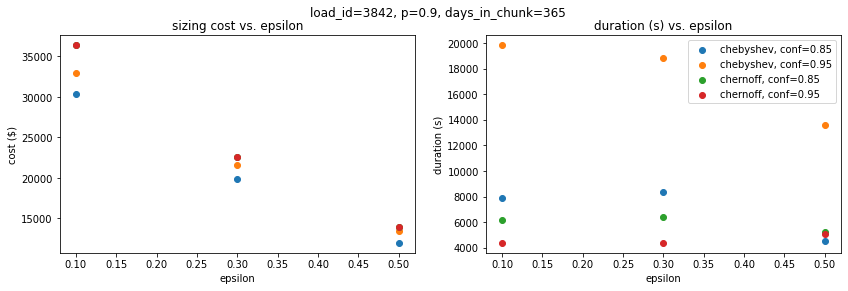

In [110]:
plot_by_epsilon(df_exp)